# **Renewables Scenario Generation GAN**

Unofficial implementation in Tensorflow 2.

Y. Chen, Y. Wang, D. Kirschen and B. Zhang, "Model-Free Renewable Scenario Generation Using Generative Adversarial Networks," in IEEE Transactions on Power Systems, vol. 33, no. 3, pp. 3265-3275, May 2018, doi: 10.1109/TPWRS.2018.2794541

Notebook Author: https://github.com/haufjan

### **Import**

In [ ]:
import os
import csv
from time import gmtime, strftime, time
import numpy as np
import tensorflow as tf
import keras
from keras.initializers import Initializer, RandomNormal
from keras.layers import BatchNormalization, Conv2DTranspose, Conv2D, Dense, LeakyReLU, ReLU
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from scipy.signal import welch

### **Functions**

In [ ]:
def load_solar_data(path_data: str, path_labels: str) -> tuple:
    """
    Load and preprocess solar data and labels for GAN training.
    """
    with open(f'{path_data}' if path_data.endswith('csv') else f'{path_data}.csv', 'r') as csvfile:
        rows = np.array(list(csv.reader(csvfile)), dtype=float)
    # Specify according to time points in your own dataset
    rows = rows[:104832,:]
    print('\nShape rows (data raw):', rows.shape)

    with open(f'{path_labels}' if path_labels.endswith('csv') else f'{path_labels}.csv', 'r') as csvfile:
        labels = np.array(list(csv.reader(csvfile)), dtype=int)
    print('\nShape labels (labels raw):', labels.shape)

    # Transform data to conform with GAN image input dimensions (24x24 = 576)
    tr_x = np.reshape(rows.T,(-1,576))
    print('\nShape tr_x (data preprocessed):',tr_x.shape)
    tr_y = np.tile(labels,(32,1))
    print('\nShape tr_y (labels preprocessed):', tr_y.shape)
    m = np.ndarray.max(rows)
    print("\nMax(Solar) =", m)
    tr_x = tr_x/m

    return tr_x, tr_y, m

In [ ]:
def encode_onehot(X, n: int = None, negative_class: float = 0.0) -> np.ndarray:
    """
    Function for encoding ordinal labels into OneHot representation.

    Args:
        x (array_like): Input labels
        n (int): Set number of ordinal labels otherwise it's inferred from data
        negative_class (float): Default value for non-activated classes
    Returns:
        x_oh (np.ndarray): OneHot encoded labels
    """
    X = np.asarray(X).flatten()
    if n is None:
        n = np.max(X) + 1
    x_oh = np.ones((len(X), n)) * negative_class
    for i in range(len(X)):
        m = X[i]
        x_oh[i,m] = 1
    return x_oh

### **Load Data**

In [ ]:
# Load and preprocess the data and labels
tr_x, tr_y, m = load_solar_data(os.path.join('solar.csv'), os.path.join('solar_label.csv'))

# Find number of unique ordinal labels
events_num = len(np.unique(tr_y))


Shape rows (data raw): (104832, 32)

Shape labels (labels raw): (182, 1)

Shape tr_x (data preprocessed): (5824, 576)

Shape tr_y (labels preprocessed): (5824, 1)

Max(Solar) = 8.13


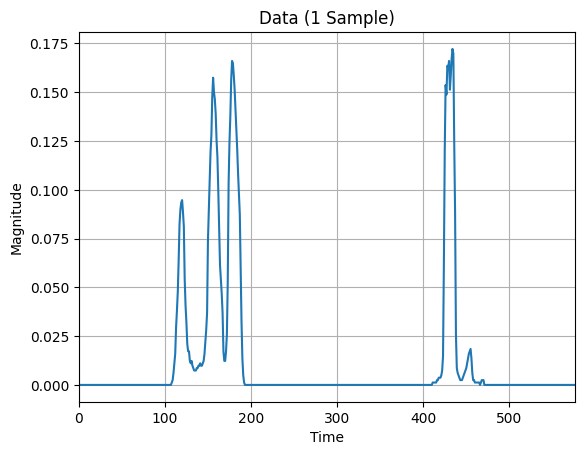

In [ ]:
# Plot one sample from the data
fig, ax = plt.subplots()
ax.plot(tr_x[0,:])
ax.set_xlim(0, tr_x.shape[-1])
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude')
ax.set_title('Data (1 Sample)')
ax.grid(True)

### **Networks**

##### **Generator**

In [ ]:
class Generator(keras.Model):
    """
    Generator network for the GAN model.
    """
    def __init__(self,
                 batch_size: int = 32,
                 dim_y: int = 6,
                 dim_z: int = 100,
                 dim_w1: int = 1024,
                 dim_w2: int = 128,
                 dim_w3: int = 64,
                 dim_channel: int = 1,
                 initializer: Initializer = RandomNormal(mean=0.0, stddev=0.02, seed=42)):
        super().__init__(name='Generator')

        # Attributes
        self.batch_size = batch_size
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.dim_w1 = dim_w1
        self.dim_w2 = dim_w2
        self.dim_w3 = dim_w3
        self.dim_channel = dim_channel

        # Layers
        self.layer1_dense = Dense(units=dim_w1,
                                  use_bias=False,
                                  kernel_initializer=initializer)
        self.layer1_batchnorm = BatchNormalization(epsilon=1e-8,
                                                   beta_initializer=initializer,
                                                   gamma_initializer=initializer)
        self.layer1_activation = ReLU()

        self.layer2_dense = Dense(units=dim_w2*6*6,
                                  use_bias=False,
                                  kernel_initializer=initializer)
        self.layer2_batchnorm = BatchNormalization(epsilon=1e-8,
                                                   beta_initializer=initializer,
                                                   gamma_initializer=initializer)
        self.layer2_activation = ReLU()

        self.layer3_conv = Conv2DTranspose(filters=dim_w3,
                                           kernel_size=5,
                                           strides=(2,2),
                                           padding='same',
                                           kernel_initializer=initializer,
                                           bias_initializer=initializer)
        self.layer3_batchnorm = BatchNormalization(epsilon=1e-8,
                                                   beta_initializer=initializer,
                                                   gamma_initializer=initializer)
        self.layer3_activation = ReLU()

        self.layer4_conv = Conv2DTranspose(filters=dim_channel,
                                           kernel_size=5,
                                           strides=(2,2),
                                           padding='same',
                                           kernel_initializer=initializer,
                                           bias_initializer=initializer)
        self.layer4_batchnorm = BatchNormalization(epsilon=1e-8,
                                                   beta_initializer=initializer,
                                                   gamma_initializer=initializer)

    def call(self, z: tf.Tensor, y: tf.Tensor, training: bool = True):
        """
        Forward pass through the generator network.

        Args:
            z (tf.Tensor): Noise
            y (tf.Tensor): OneHot encoded labels
            training (bool): Training mode for batch normalization
        Returns:
            tf.Tensor: Generated samples
        """
        yb = tf.reshape(y, [self.batch_size, 1, 1, self.dim_y])
        z = tf.concat([z, y], -1)
        h1 = self.layer1_activation(self.layer1_batchnorm(self.layer1_dense(z), training=training))
        h1 = tf.concat([h1, y], -1)
        h2 = self.layer2_activation(self.layer2_batchnorm(self.layer2_dense(h1), training=training))
        h2 = tf.reshape(h2, [self.batch_size, 6, 6, self.dim_w2])
        h2 = tf.concat([h2, yb*tf.ones([self.batch_size, 6, 6, self.dim_y])], -1)
        h3 = self.layer3_activation(self.layer3_batchnorm(self.layer3_conv(h2), training=training))
        h3 = tf.concat([h3, yb*tf.ones([self.batch_size, 12, 12, self.dim_y])], -1)
        h4 = self.layer4_batchnorm(self.layer4_conv(h3), training=training)

        return h4

##### **Discriminator**

In [ ]:
class Discriminator(keras.Model):
    """
    Discriminator network for the GAN model.
    """
    def __init__(self,
                 batch_size: int = 32,
                 dim_y: int = 6,
                 dim_z: int = 100,
                 dim_w1: int = 1024,
                 dim_w2: int = 128,
                 dim_w3: int = 64,
                 dim_channel: int = 1,
                 initializer: Initializer = RandomNormal(mean=0.0, stddev=0.02, seed=42)):
        super().__init__(name='Discriminator')

        # Attributes
        self.batch_size = batch_size
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.dim_w1 = dim_w1
        self.dim_w2 = dim_w2
        self.dim_w3 = dim_w3
        self.dim_channel = dim_channel

        # Layers
        self.layer1_conv = Conv2D(filters=dim_w3,
                                  kernel_size=5,
                                  strides=(2,2),
                                  padding='same',
                                  kernel_initializer=initializer,
                                  bias_initializer=initializer)
        self.layer1_activation = LeakyReLU(negative_slope=0.2)

        self.layer2_conv = Conv2D(filters=dim_w2,
                                  kernel_size=5,
                                  strides=(2,2),
                                  padding='same',
                                  kernel_initializer=initializer,
                                  bias_initializer=initializer)
        self.layer2_batchnorm = BatchNormalization(epsilon=1e-8,
                                                   beta_initializer=initializer,
                                                   gamma_initializer=initializer)
        self.layer2_activation = LeakyReLU(negative_slope=0.2)

        self.layer3_dense = Dense(units=dim_w1, use_bias=False, kernel_initializer=initializer)
        self.layer3_batchnorm = BatchNormalization(epsilon=1e-8,
                                                   beta_initializer=initializer,
                                                   gamma_initializer=initializer)
        self.layer3_activation = LeakyReLU(negative_slope=0.2)

    def call(self, image: tf.Tensor, y: tf.Tensor, training: bool = True):
        """
        Forward pass through the discriminator network.

        Args:
            image (tf.Tensor): Generated or real samples
            y (tf.Tensor): OneHot encoded labels
            training (bool): Training mode for batch normalization
        Returns:
            tf.Tensor: Discriminator output
        """
        yb = tf.reshape(y, [self.batch_size, 1, 1, self.dim_y])
        x = tf.concat([image, yb*tf.ones([self.batch_size, 24, 24, self.dim_y])], -1)
        h1 = self.layer1_activation(self.layer1_conv(x))
        h1 = tf.concat([h1, yb*tf.ones([self.batch_size, 12, 12, self.dim_y])], -1)
        h2 = self.layer2_activation(self.layer2_batchnorm(self.layer2_conv(h1), training=training))
        h2 = tf.reshape(h2, [self.batch_size, -1])
        h2 = tf.concat([h2, y], -1)
        h3 = self.layer3_activation(self.layer3_batchnorm(self.layer3_dense(h2), training=training))

        return h3

### **Loss Functions**

In [ ]:
@tf.function
def generator_cost(raw_gen2: tf.Tensor) -> tf.Tensor:
    """
    Generator loss using Wasserstein distance.
    """
    return -tf.math.reduce_mean(raw_gen2, axis=None)

In [ ]:
@tf.function
def discriminator_cost(raw_real2: tf.Tensor, raw_gen2: tf.Tensor) -> tf.Tensor:
    """
    Discriminator loss using Wasserstein distance.
    """
    return tf.math.reduce_sum(raw_gen2, axis=None) - tf.math.reduce_sum(raw_real2, axis=None)

### **GAN**

In [ ]:
class GAN():
    """
    Renewables Scenario Generation Generative Adversarial Networks.
    """
    def __init__(self,
                 epochs: int = 1000,
                 batch_size: int = 32,
                 image_shape: tuple = (24, 24, 1),
                 dim_y: int = 6,
                 dim_z: int = 100,
                 dim_w1:int = 1024,
                 dim_w2: int = 128,
                 dim_w3: int = 64,
                 dim_channel: int = 1,
                 learning_rate: float = 1e-4):

        # Attributes
        self.epochs = epochs
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.dim_w1 = dim_w1
        self.dim_w2 = dim_w2
        self.dim_w3 = dim_w3
        self.dim_channel = dim_channel
        self.learning_rate = learning_rate
        self.normal = (0, 0.1)
        self.rng = np.random.default_rng(42)

        # Initialization of weights
        initializer = RandomNormal(mean=0.0, stddev=0.02, seed=42)

        # Instantiate generator and discriminator network
        self.generator = Generator(batch_size, dim_y, dim_z, dim_w1, dim_w2, dim_w3, dim_channel, initializer)
        self.discriminator = Discriminator(batch_size, dim_y, dim_z, dim_w1, dim_w2, dim_w3, dim_channel, initializer)

        # Optimizers
        self.optimizer_g = RMSprop(learning_rate=learning_rate)
        self.optimizer_d = RMSprop(learning_rate=learning_rate)

        # Loss functions
        self.generator_loss = generator_cost
        self.discriminator_loss = discriminator_cost

        # Auxiliary
        self.fitting_time = None

    def fit(self, x: np.ndarray, y: np.ndarray) -> None:
        """
        Train the GAN model on the provided data and labels.

        Args:
            x (ndarray): Data
            y (ndarray): Labels
        Returns:
            None
        """
        self.fitting_time = time()
        iterations = 0

        # Control balance of training discriminator vs generator; default k = 4
        k = 4

        # Define generator train step
        @tf.function
        def train_step_g(xs, ys, zs):
            with tf.GradientTape() as tape:
                h4 = self.generator(zs, ys)
                image_gen = tf.sigmoid(h4)
                raw_gen2 = self.discriminator(image_gen, ys)
                p_gen_val = tf.math.reduce_mean(raw_gen2, axis=None)

                gen_loss_val = self.generator_loss(raw_gen2)

                raw_real2 = self.discriminator(xs, ys)
                p_real_val = tf.math.reduce_mean(raw_real2, axis=None)

                discrim_loss_val = self.discriminator_loss(raw_real2, raw_gen2)

            grad_g = tape.gradient(gen_loss_val, self.generator.trainable_variables)
            self.optimizer_g.apply_gradients(zip(grad_g, self.generator.trainable_variables))

            return p_gen_val, p_real_val, discrim_loss_val, gen_loss_val

        # Define discriminator train step
        @tf.function
        def train_step_d(xs, ys, zs):
            with tf.GradientTape() as tape:
                h4 = self.generator(zs, ys)
                image_gen = tf.sigmoid(h4)
                raw_gen2 = self.discriminator(image_gen, ys)
                p_gen_val = tf.math.reduce_mean(raw_gen2, axis=None)

                gen_loss_val = self.generator_loss(raw_gen2)

                raw_real2 = self.discriminator(xs, ys)
                p_real_val = tf.math.reduce_mean(raw_real2, axis=None)

                discrim_loss_val = self.discriminator_loss(raw_real2, raw_gen2)

            grad_d = tape.gradient(discrim_loss_val, self.discriminator.trainable_variables)
            self.optimizer_d.apply_gradients(zip(grad_d, self.discriminator.trainable_variables))

            return p_gen_val, p_real_val, discrim_loss_val, gen_loss_val

        p_real = []
        p_fake = []
        discrim_loss = []
        gen_loss = []

        # Transform labels into OneHot-representation
        y_oh = encode_onehot(y, n=self.dim_y)

        for epoch in range(self.epochs):
            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('Epoch:', epoch + 1)

            zs = self.rng.normal(self.normal[0], self.normal[1], size=(len(y), self.dim_z))

            ds_train = tf.data.Dataset.from_tensor_slices((x.astype(np.float32),
                                                           y_oh.astype(np.float32),
                                                           zs.astype(np.float32))).cache().shuffle(buffer_size=len(y))

            for xs, ys, zs in ds_train.batch(self.batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE):
                xs = tf.reshape(xs, [-1, *self.image_shape])

                if iterations % k == 0:
                    p_gen_val, p_real_val, discrim_loss_val, gen_loss_val = train_step_g(xs, ys, zs)
                else:
                    p_gen_val, p_real_val, discrim_loss_val, gen_loss_val = train_step_d(xs, ys, zs)

                p_fake.append(p_gen_val)
                p_real.append(p_real_val)
                discrim_loss.append(discrim_loss_val)
                gen_loss.append(gen_loss_val)

                if iterations % 1000 == 0:
                    print('Iterations',
                          iterations,
                          '| Average P(real):', f'{p_real_val:12.9f}',
                          '| Average P(fake):', f'{p_gen_val:12.9f}',
                          '| Discriminator Loss:', f'{discrim_loss_val:12.9f}',
                          '| Generator Loss:', f'{gen_loss_val:12.9f}')

                iterations += 1

        self.fitting_time = np.round(time() - self.fitting_time, 3)
        print('\nElapsed Training Time: ' + strftime('%Hh %Mmin %Ss', gmtime(self.fitting_time)))

        # Plotting
        fig, ax = plt.subplots()
        ax.plot(p_real, label='real')
        ax.plot(p_fake, label='fake')
        ax.legend()
        ax.set_xlim(0, len(p_real))
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Wasserstein Distance')
        ax.grid(True)
        fig.show()

        fig, ax = plt.subplots()
        ax.plot(discrim_loss)
        ax.set_xlim(0, len(discrim_loss))
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Discriminator Loss')
        ax.grid(True)
        fig.show()

    def predict(self) -> tuple:
        """
        Generate data using the trained generator conditioned on randomly sampled labels.
        """
        @tf.function
        def generate_step(zs: tf.Tensor, y_np_sample: tf.Tensor) -> tf.Tensor:
            return tf.sigmoid(self.generator(zs, y_np_sample, training=False))

        generated_labels = self.rng.integers(self.dim_y, size=(self.batch_size, 1))
        y_np_sample = encode_onehot(generated_labels, n=self.dim_y)
        zs = self.rng.normal(self.normal[0], self.normal[1], size=(self.batch_size, self.dim_z))

        ds_generate = tf.data.Dataset.from_tensor_slices((zs.astype(np.float32),
                                                          y_np_sample.astype(np.float32))).cache()

        for zs, y_np_sample in ds_generate.batch(len(zs), drop_remainder=True).prefetch(tf.data.AUTOTUNE):
            generated_samples = generate_step(zs, y_np_sample)

        # Inverse transform from image shape (24x24 = 576) into time series
        generated_samples = np.reshape(generated_samples.numpy(), (-1, 576))

        return generated_samples, generated_labels

### **GPU-Accelerator**

In [ ]:
if tf.config.list_physical_devices('GPU'):
    print(tf.config.list_physical_devices('GPU'))
    tf.config.set_soft_device_placement(True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### **Instantiate GAN Model**

In [ ]:
# Create GAN model instance with specified parameters
gan_model = GAN(epochs=300,
                learning_rate=1e-3,
                dim_y=events_num)

### **Train GAN Model**

Iterations 0 | Average P(real):  0.007857574 | Average P(fake):  0.007851912 | Discriminator Loss: -0.185546875 | Generator Loss: -0.007851912
Iterations 1000 | Average P(real):  0.232131958 | Average P(fake):  0.095109373 | Discriminator Loss: -4489.956054688 | Generator Loss: -0.095109373
Iterations 2000 | Average P(real):  0.462139726 | Average P(fake):  0.177833050 | Discriminator Loss: -9316.161132812 | Generator Loss: -0.177833050
Iterations 3000 | Average P(real):  0.694364190 | Average P(fake):  0.223456740 | Discriminator Loss: -15430.695312500 | Generator Loss: -0.223456740
Iterations 4000 | Average P(real):  0.929281294 | Average P(fake):  0.298902154 | Discriminator Loss: -20656.263671875 | Generator Loss: -0.298902154
Iterations 5000 | Average P(real):  1.152117491 | Average P(fake):  0.487643838 | Discriminator Loss: -21773.472656250 | Generator Loss: -0.487643838
Epoch: 30
Iterations 6000 | Average P(real):  1.382990718 | Average P(fake):  0.516725183 | Discriminator Los

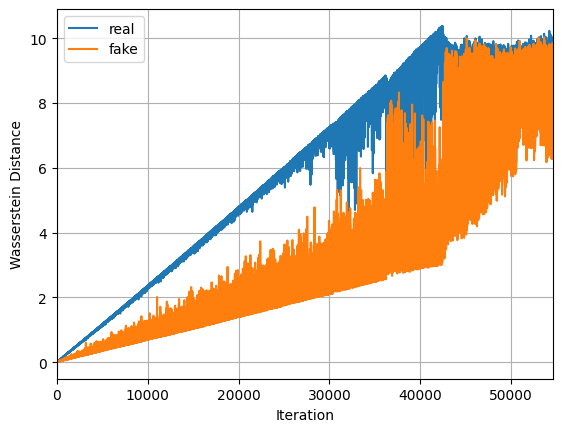

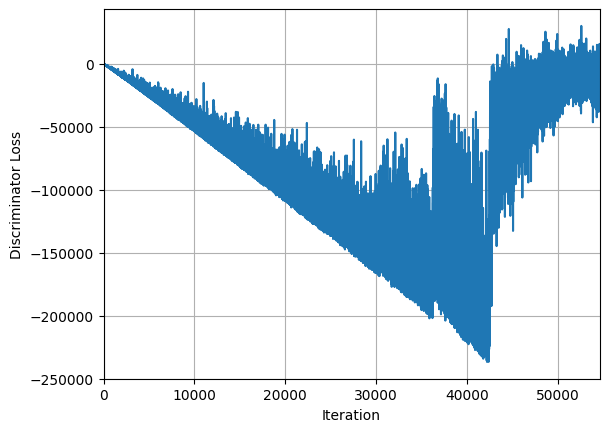

In [ ]:
# Start training
gan_model.fit(tr_x, tr_y)

### **Generate Data**

In [ ]:
# Sample a set of labels and generate data
data_gen, labels_sampled = gan_model.predict()

# Rescaling
data_real = tr_x*m
data_gen = data_gen*m

### **Evaluation**

In [ ]:
def visualize_resuls(data_real: np.ndarray, data_gen: np.ndarray, labels: np.ndarray, labels_sampled: np.ndarray) -> None:
    # Find unique ordinal labels within samples
    labels_unique = np.unique(labels_sampled)

    # Sampling frequency of 5 min resolution in Hz
    fs = 1/(60*5)

    fig, ax = plt.subplots(len(labels_unique), 2, figsize=(8, 2*len(labels_unique)), layout='constrained')
    for i, label in enumerate(labels_unique):
        # Get indices to organize by ordinal labels
        indices_real, _ = np.nonzero(labels == label)
        indices_gen, _ = np.nonzero(labels_sampled == label)

        # Left column
        ax[i,0].fill_between(np.arange(0, data_real.shape[-1]), np.max(data_real[indices_real], 0), np.min(data_real[indices_real], 0), alpha=0.2)
        ax[i,0].plot(np.mean(data_real[indices_real], 0))
        ax[i,0].plot(data_gen[indices_gen].transpose(), alpha=0.5)
        ax[i,0].set_xlabel('Time (5 min)')
        ax[i,0].set_ylabel('Generated Power (MW)')
        ax[i,0].set_xlim(0, data_gen.shape[-1])
        ax[i,0].grid(True)

        # Right column
        f_real, pden_real = welch(data_real[indices_real,:], fs, nperseg=128)
        f_gen, pden_gen = welch(data_gen[indices_gen,:], fs, nperseg=128)
        ax[i,1].semilogy(f_real, np.mean(pden_real, 0))
        ax[i,1].fill_between(f_real, np.max(pden_real, 0), np.min(pden_real, 0), alpha=0.2)
        ax[i,1].semilogy(f_gen, pden_gen.transpose(), alpha=0.5)
        ax[i,1].set_xlim(0, max(f_real))
        ax[i,1].ticklabel_format(axis='x', style='sci', scilimits=(0, max(f_real)))
        ax[i,1].set_xlabel('Frequency (Hz)')
        ax[i,1].set_ylabel(r'PSD ($\frac{MW^2}{Hz}$)')
        ax[i,1].grid(True)

    # fig.savefig('generated_data.png', bbox_inches='tight')
    fig.show()

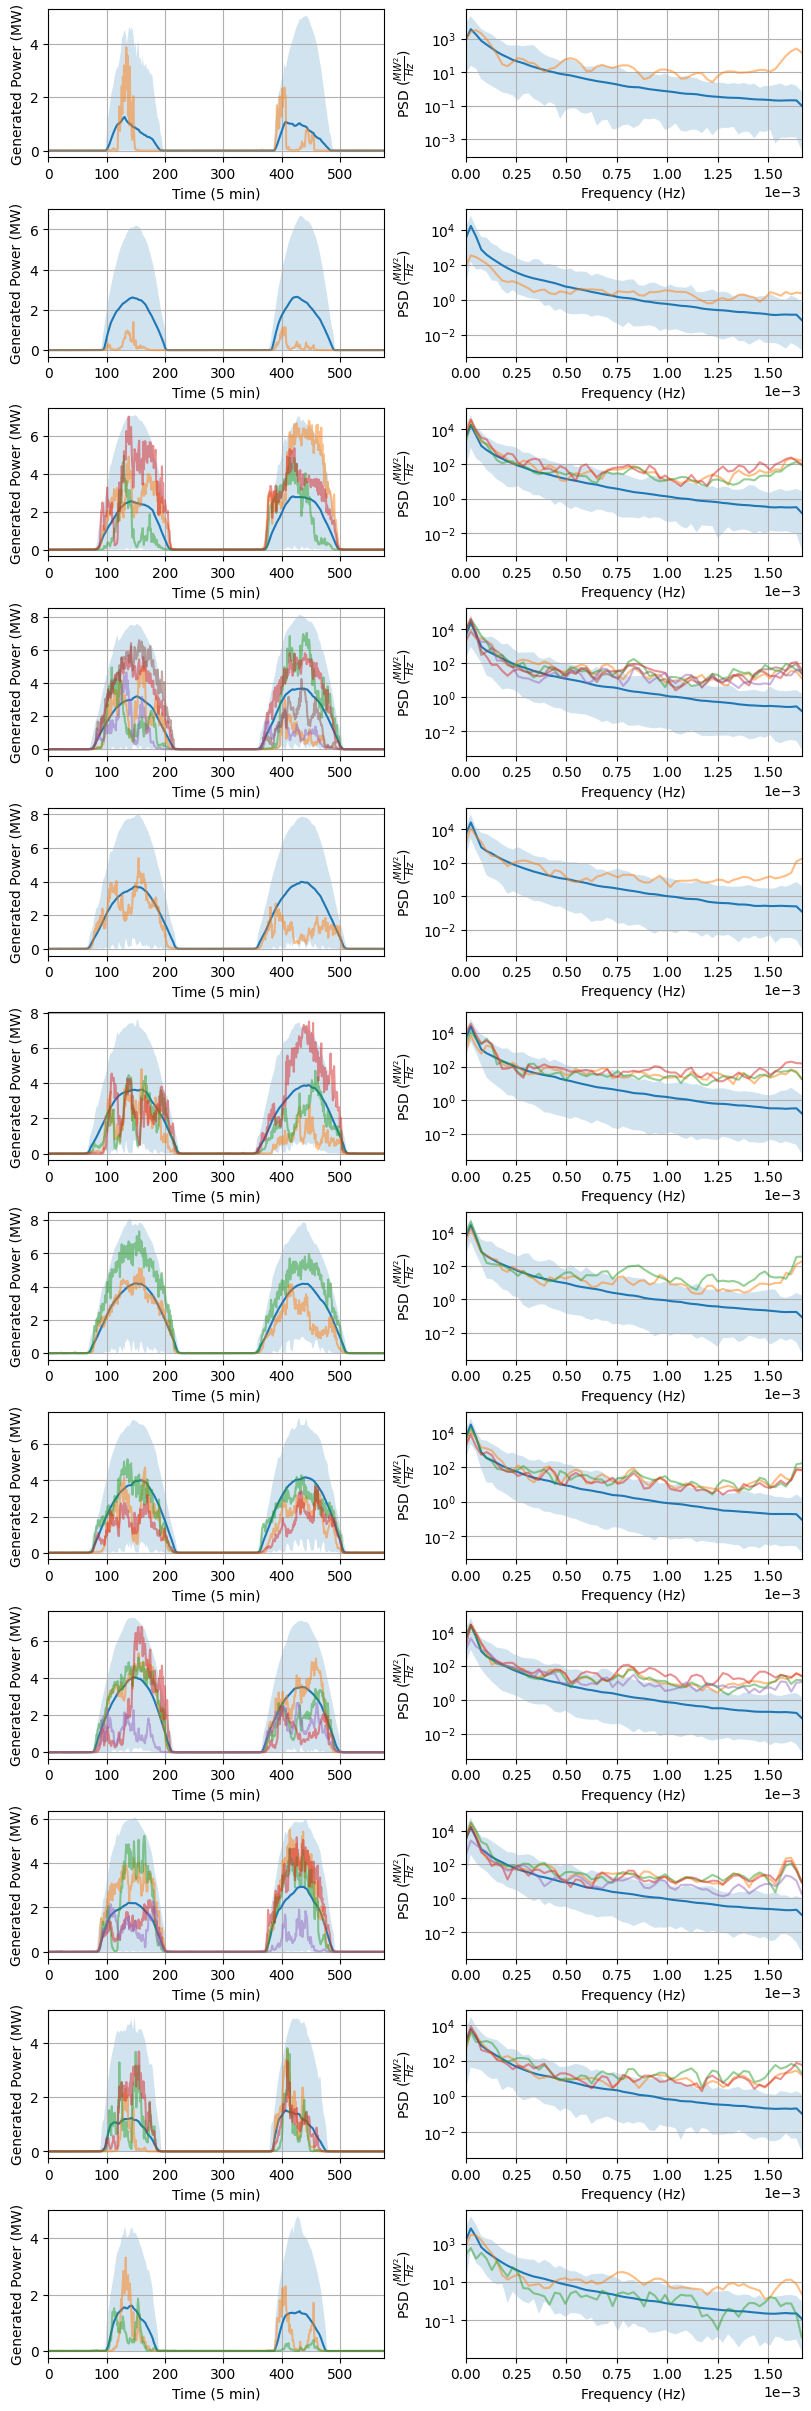

In [ ]:
visualize_resuls(data_real, data_gen, tr_y, labels_sampled)
plt.show()